In [1]:
import pandas as pd

from typing import *

import yargy as y
import yargy.predicates as yp
import yargy.morph as ytm
import yargy.tokenizer as yt

from pymorphy2 import MorphAnalyzer
from isanlp import PipelineCommon
from isanlp.processor_remote import ProcessorRemote
from isanlp.ru.processor_mystem import ProcessorMystem
from isanlp.ru.converter_mystem_to_ud import ConverterMystemToUd 

from pyhash import city_32
from rich import print
import joblib as jb
import json

from rich import print
import razdel

import os

from functools import lru_cache
CACHE_SIZE=10000

In [2]:
class MostProbMorphAnalyzer(ytm.MorphAnalyzer):

    def __call__(self, word):
        records = self.raw.parse(word)
        max_score = max(x.score for x in records)
        records = list(filter(lambda x: x.score == max_score, records))
        return [ytm.prepare_form(record) for record in records]
    
    
class CachedMostProbMorphAnalyzer(MostProbMorphAnalyzer):
    def __init__(self):
        super(CachedMostProbMorphAnalyzer, self).__init__()
        
    __call__ = lru_cache(CACHE_SIZE)(MostProbMorphAnalyzer.__call__)

In [3]:
rules = pd.read_csv("../data/rules/rules_formatted.csv")

In [4]:
predicates_ = pd.read_csv("../data/rules/predicates.csv")

In [5]:
deverbal_nouns = set(predicates_[predicates_.type == 'deverbal_noun'].predicate.to_list())
predicates = set(predicates_[predicates_.type == 'predicate'].predicate.to_list())
status_categories = set(predicates_[predicates_.type == 'status_category'].predicate.to_list())
rule_specific = set(rules.predicate.to_list())

In [6]:
all_predicates = predicates | deverbal_nouns | status_categories | rule_specific

In [7]:
all_predicates -= {'?'}

In [8]:
def create_predicate_rule(
    require_deverbal_noun: str,
    require_reflexive: str,
    require_status_category: str,
    predicate: str,
    **kwargs
):
    rule_id = f"predicate={predicate},deverbal={require_deverbal_noun},reflexive={require_reflexive},status_category={require_status_category}"
    return rule_id, y.rule(
        y.and_(
            req_predicate(predicate),
            req_deverbal(require_deverbal_noun),
            req_reflexive(require_reflexive)
        )
    )

In [9]:
def create_argument_role(argument_type: str, case: str, preposition: str, **kwargs):
    rule_id = f"argument_type={argument_type},case={case},preposition={preposition}"
    arg = y.and_(
        req_argument(),
        req_animacy(argument_type),
        req_case(case)
    )
    internal = y.and_(
        yp.gram("ADJF"), 
        y.or_(
            yp.normalized("этот"),
            yp.normalized("тот")
        )
    )
    
    rule = y.or_(
        y.rule(req_preposition(preposition), arg),
        y.rule(req_preposition(preposition), internal, arg)
    )
    return rule_id, rule

In [10]:
def req_deverbal(require_deverbal_noun: str = '?'):
    if require_deverbal_noun == '1': ## strictly deverbal noun
        return y.and_(
            yp.gram("NOUN"),
            yp.in_caseless(deverbal_nouns)
        )
    elif require_deverbal_noun == '0': ## strictly regular verb
        return y.or_(
            yp.gram("VERB"),
            yp.gram("INFN")
        )
    elif require_deverbal_noun == '?': ## anything
        return y.or_(
            y.and_(
                yp.gram("NOUN"),
                yp.in_caseless(deverbal_nouns)
            ),
            yp.gram("VERB"),
            yp.gram("INFN")
        )
    else:
        raise ValueError("Incorrect deverbal status")

In [11]:
def req_reflexive(reflexive_status: str = '?'):
    
    def is_reflexive_verb(verb: str):
        return verb.endswith("ся") or verb.endswith("сь")
    
    if reflexive_status == "1":
        return yp.custom(is_reflexive_verb)
    if reflexive_status == "0":
        return y.not_(yp.custom(is_reflexive_verb))
    elif reflexive_status == "?":
        return yp.true()
    else:
        raise ValueError ("Incorrect reflexive status")

In [12]:
def req_animacy(animacy: str = 'любой'):
    if animacy == 'любой':
        return yp.true()
    elif animacy == 'одуш.':
        return y.or_(
            y.not_(yp.gram('inan')),
            yp.gram("anim"),
            yp.gram("NPRO"),
            yp.gram("ADJF")
        )
    else:
        raise ValueError("Incorrect Animacy Type")

In [13]:
def req_argument():
    return y.and_(
        y.not_(
            y.or_( ## prohibits arguments from being any of following parts-of-speech
                yp.gram('PREP'),
                yp.gram("CONJ"),
                yp.gram('PRCL'),
                yp.gram("INTJ"),
                yp.gram("ADJF")
            )
        ),
        y.or_(
            yp.gram("NOUN"),
            yp.gram("NPRO")
        )
    )

In [14]:
def req_predicate(word: str = "?"):
    predicate = y.or_(
        yp.gram("VERB"),
        yp.gram("INFN"),
        yp.gram("NOUN")
    )
    if word != '?':
        predicate = y.and_(
            yp.normalized(word),
            predicate
        )
        
    return predicate

In [15]:
from collections import defaultdict

In [16]:
def req_case(case: str = 'в'):
    if case == 'в':
        pred = yp.gram("accs")
    elif case == 'т':
        pred = yp.gram("ablt")
    elif case == 'д':
        pred = yp.gram('datv')
    elif case == 'р':
        pred = yp.gram("gent")
    elif case == 'и':
        pred = yp.gram("nomn")
    else:
        raise ValueError("Incorrect Case")
    
    return y.or_(pred)

In [17]:
def req_preposition(preposition: str = None):
    if preposition == 'None':
        return y.empty()
    else:
        return y.and_(
            yp.gram("PREP"),
            yp.eq(preposition)
        )

In [18]:
def soft_parser_pass(parser, text):
    matches = []
    for match in parser.findall(text):
        matches.append({
            'text': " ".join([x.value for x in match.tokens]),
            'span': tuple(match.span)
        })

    return matches

In [19]:
def strict_parser_pass(parser, text):
    match = parser.match(text)
    matches.append({
        'text': " ".join([x.value for x in match.tokens]),
        'span': tuple(match.span)
    })

    return [match]

In [20]:
def create_rules(**kwargs):
    predicate_rule_id, predicate_rule = create_predicate_rule(**kwargs)
    argument_rule_id, argument_rule = create_argument_role(**kwargs)
    return {
        'predicate_id': predicate_rule_id,
        'argument_id': argument_rule_id,
        'predicate_parser': y.Parser(predicate_rule, yt.MorphTokenizer(morph=CachedMostProbMorphAnalyzer())),
        'argument_parser': y.Parser(argument_rule, yt.MorphTokenizer(morph=CachedMostProbMorphAnalyzer()))
    }

In [21]:
roleset = set(rules.role)

In [22]:
ruleset = {}

In [23]:
from tqdm.auto import tqdm

In [24]:
for role in roleset:
    ruleset[role] = []
    
    for rule_dict in tqdm(rules[rules.role == role].to_dict(orient='records'), desc=role):
        ruleset[role].append(create_rules(**rule_dict))

In [25]:
argument_rules = {}
for role in ruleset.keys():
    for rule in ruleset[role]:
        argument_rules[f"{rule['argument_id']}+{role}"] = {
            'role':role,
            'argument_parser': rule['argument_parser']
        }

In [26]:
predicate_orient = {}
for role in ruleset.keys():
    for rule in ruleset[role]:
        rule_id = rule['predicate_id']
        if rule_id not in predicate_orient:
            predicate_orient[rule_id] = {}
            predicate_orient[rule_id]['predicate_parser'] = rule['predicate_parser']
            predicate_orient[rule_id]['arguments'] = []
            
        predicate_orient[rule_id]['arguments'].append({
            'role': role,
            'argument_id': rule['argument_id'],
            'argument_parser': rule['argument_parser']
        })

In [27]:
predicate_orient_rules = {}
for predicate_id in predicate_orient.keys():
    argument_tuples = set([
        f"{x['argument_id']}+{x['role']}" for x in predicate_orient[predicate_id]['arguments']
    ])
    predicate_orient_rules[predicate_id] = {
        'predicate_parser': predicate_orient[predicate_id]['predicate_parser'],
        'arguments': [argument_rules[key] for key in argument_tuples]
    }

In [28]:
import yargy.pipelines as pipelines

In [29]:
filter_pipeline = y.Parser(
    pipelines.morph_pipeline(list(all_predicates)),
    tokenizer=yt.MorphTokenizer(
        morph=CachedMostProbMorphAnalyzer()
    )
)

In [30]:
def check_parseable(text, parser):
    return len(list(parser.findall(text))) > 0

In [31]:
class ArgumentExtractor:
    
    def __init__(self, *args, **kwargs):
        pass
    
    def extract(self, sentence: str) -> List[Dict[str, Any]]:
        pass

In [32]:
from ufal.udpipe import Model, Pipeline, ProcessingError
from predpatt import PredPatt, load_conllu
from predpatt import PredPattOpts
from predpatt.util.ud import dep_v1, dep_v2

class PredPattArgumentExtractor(ArgumentExtractor):
    def __init__(
        self,
        path_to_udpipe: str,
        resolve_relcl: bool = True,
        resolve_appos: bool = True,
        resolve_amod: bool = True,
        resolve_conj: bool = True,
        resolve_poss: bool = True,
        ud = dep_v2.VERSION
    ):
        super().__init__()
        self.model = Model.load(path_to_udpipe)
        self.pipeline = Pipeline(self.model, 'tokenize', Pipeline.DEFAULT, Pipeline.DEFAULT, 'conllu')
        self._error = ProcessingError()
        self._opts = PredPattOpts(
            resolve_relcl=resolve_relcl,
            resolve_appos=resolve_appos,
            resolve_amod=resolve_amod,
            resolve_conj=resolve_conj,
            resolve_poss=resolve_poss,
            ud=ud
        )
        
    def extract(self, sentence: str) -> List[Dict[str, Any]]:
        processed = self.pipeline.process(sentence, self._error)
        if self._error.occurred():
            print(f"=== Error occurred: {self._error.message}")
            self._error = ProcessingError()
            return None
        else:
            conll_example = [ud_parse for sent_id, ud_parse in load_conllu(processed)][0]
            ppatt = PredPatt(conll_example, opts=self._opts)
            result = []
            for predicate in ppatt.instances:
                structure = {
                    'predicate': predicate.tokens,
                    'arguments': [x.tokens for x in predicate.arguments]
                }
                result.append(structure)
                
            return result        

In [33]:
from collections import defaultdict
class MainPhraseExtractor:
    
    def __init__(self, syntax_parser, pymorphy_analyzer):
        self.syntax = syntax_parser
        self.morph = pymorphy_analyzer

    def get_main_phrase(self, words, get_prep=False, verbose=False):
        markup = next(self.syntax.map([words]))
        forward = {}
        backward = defaultdict(list)
        token_map = {}
        candidates = []
        for token in markup.tokens:
            if token.head_id not in backward:
                backward[token.head_id] = []

            token_map[token.id] = token
            forward[token.id] = token.head_id
            backward[token.head_id].append(token.id)

            if token.id == token.head_id or token.head_id == '0':
                candidates.append(token.id)
             
        if verbose:
            print("forward ", forward)
            print("backward ", backward)
            print("candidates ", candidates)
                
        if len(candidates) == 0:
            return markup.tokens

        candidate = sorted(candidates, key=lambda x: len(backward[x]))[-1]
        if get_prep:
            prep_candidates = backward[candidate]
            prep_candidates = list(
                filter(lambda x: self.morph.tag(token_map[x].text)[0].POS == 'PREP', prep_candidates)
            )
            if len(prep_candidates) == 0:
                return [token_map[candidate]]
            
            prep = sorted(prep_candidates, key=lambda x: abs(int(x) - int(candidate)))[0]
            return (token_map[prep], token_map[candidate])

        return [token_map[candidate]]

In [34]:
class RstClauseSeparator:
    def __init__(self, udpipe=('tsa05.isa.ru', 3334), rst=('tsa05.isa.ru', 3335), cache_path="./rst-cache.pkl"):
        udpipe_host, udpipe_port = udpipe
        rst_host, rst_port = rst
        self.cache_path = cache_path
        self.ppl = PipelineCommon([
            (ProcessorRemote(udpipe_host, udpipe_port, '0'),
             ['text'],
             {'sentences': 'sentences',
              'tokens': 'tokens',
              'lemma': 'lemma',
              'syntax_dep_tree': 'syntax_dep_tree',
              'postag': 'ud_postag'}),
            (ProcessorMystem(delay_init=False),
             ['tokens', 'sentences'],
             {'postag': 'postag'}),
            (ConverterMystemToUd(),
             ['postag'],
             {'morph': 'morph',
              'postag': 'postag'}),
            (ProcessorRemote(rst_host, rst_port, 'default'),
             ['text', 'tokens', 'sentences', 'postag', 'morph', 'lemma', 'syntax_dep_tree'],
             {'rst': 'rst'})
        ])
        self.__cache = {}
        self.__hasher = city_32()
        if os.path.exists(self.cache_path):
            self.__cache = jb.load(self.cache_path)
        
    def extract(self, text):
        text_hash = self.__hasher(text)
        if text_hash in self.__cache:
            return self.__cache[text_hash]
        else:
            result = self.ppl(text)
            clauses = [x.text for x in result['rst']]
            self.__cache[text_hash] = clauses
            return clauses
        
        
    def flush(self):
        jb.dump(self.__cache, self.cache_path)

In [35]:
class RoleLabeler:
    def __init__(
        self,
        argument_extractor: ArgumentExtractor,
        main_phrase_extractor: MainPhraseExtractor,
        filter_pipeline,
        predicate_ruleset,
        mode: str = 'soft'
    ):
        
        self.argument_extractor = argument_extractor
        self.main_phrase_extractor = main_phrase_extractor
        self.filter_pipeline = filter_pipeline
        self.ruleset = predicate_ruleset
        if mode == 'soft':
            self.pass_fn = soft_parser_pass
        elif mode == 'strict':
            self.pass_fn = strict_parser_pass
        else:
            raise ValueError(f"Incorrect mode = {mode}, can be 'soft' or 'strict'")
            
    def check_parse(self, text, parser):
        return len(self.pass_fn(parser, text)) > 0
    
    def run(self, sentence):
        arg_groups = self.argument_extractor.extract(sentence)
        arg_groups = list(
            filter(
                lambda x: check_parseable(
                    " ".join([token.text for token in x['predicate']]),
                    self.filter_pipeline
                ),
                arg_groups
            )
        )
        result = []
        for group in arg_groups:
            
            predicate_txt = " ".join([token.text for token in group['predicate']])
            predicate_tokens = [token.text for token in group['predicate']]
            predicate_main = " ".join([x.text for x in self.main_phrase_extractor.get_main_phrase(predicate_tokens)])
            forward_map = {" ".join([token.text for token in argument]): argument for argument in group['arguments']}
            group_name = f"predicate={predicate_txt},arguments=[{','.join(forward_map.keys())}]"
            group_result = []
            for predicate in self.ruleset.values():
                if self.check_parse(predicate_main, predicate['predicate_parser']):
                    predicate_result = {
                        'predicate': predicate_txt,
                        'predicate_analyzed': predicate_main,
                        'predicate_tokens': group['predicate'],
                        'arguments': []
                    }
                    for argument in forward_map.keys():
                        argument_tokens = [x.text for x in forward_map[argument]]
                        argument_main = " ".join([
                            x.text for x in self.main_phrase_extractor.get_main_phrase(argument_tokens, True)
                        ])
                        roles = [
                            rule['role'] for rule in predicate['arguments'] 
                            if self.check_parse(argument_main, rule['argument_parser'])
                        ]
                        if len(roles) > 0: 
                            predicate_result['arguments'].append({
                                'argument': argument,
                                'argument_analyzed': argument_main,
                                'argument_tokens': forward_map[argument],
                                'roles': tuple(roles)
                            })
                    if len(predicate_result['arguments']) > 0:
                        predicate_result['arguments'] = tuple(predicate_result['arguments'])
                        group_result.append(predicate_result)
            result.append({'group': group_name, 'parses': group_result})
        return result
            

In [36]:
class ConstraintEnforcer:
    def __init__(self, constraints=None):
        if constraints is None:
            constraints = list()
            
        self.constraints = constraints
        
    def add(self, constraint):
        self.constraints.append(constraint)
        
    def enforce(self, parse):
        a_parse = parse.copy()
        for constraint in self.constraints:
            a_parse = constraint(a_parse)
            if len(a_parse) == 0:
                return a_parse
            
        return a_parse

In [37]:
from navec import Navec
from slovnet import Syntax
navec = Navec.load('../data/models/navec_news_v1_1B_250K_300d_100q.tar')
syntax = Syntax.load('../data/models/slovnet_syntax_news_v1.tar')
_ = syntax.navec(navec)

In [38]:
main_phrase_extractor = MainPhraseExtractor(syntax, MorphAnalyzer())
extractor = PredPattArgumentExtractor("../data/models/russian-syntagrus-ud-2.5-191206.udpipe")
clause_extractor = RstClauseSeparator()

In [39]:
labeler = RoleLabeler(extractor, main_phrase_extractor, filter_pipeline, predicate_orient_rules, mode='soft')

In [40]:
enforcer = ConstraintEnforcer()
def enforce_parseable_predicate(parse):
    if check_parseable(parse['predicate_analyzed'], filter_pipeline):
        return parse
    else:
        return {}
    
def reduce_duplicate_roles(parse):
    new_args = []
    for arg in parse['arguments']:
        arg['roles'] = tuple(set(arg['roles']))
        new_args.append(arg)
    parse['arguments'] = new_args
    return parse
    
def resolve_multiple_expirirencers(parse):
    if len(parse['arguments']) >= 2:
        parse_roles = set(arg['roles'] for arg in parse['arguments'])
        if ('экспериенцер',) in parse_roles:
            new_args = []
            for arg in parse['arguments']:
                if len(arg['roles']) >= 2:
                    new_roles = list(arg['roles'])
                    if 'экспериенцер' in new_roles:
                        new_roles.remove('экспериенцер')
                    arg['roles'] = tuple(new_roles)
                new_args.append(arg)
            parse['arguments'] = new_args
    return parse

def resolve_single_expiriencer(parse):
    parse_roles = [arg['roles'] for arg in parse['arguments'] if len(arg['roles']) >= 2]
    if len(parse_roles) > 0:
        n_exp = 0
        for role in parse_roles:
            if 'экспериенцер' in role:
                n_exp += 1
                
        if n_exp == 1:
            new_args = []
            for arg in parse['arguments']:
                if len(arg['roles']) >= 2 and 'экспериенцер' in arg['roles']:
                    arg['roles'] = ('экспериенцер',)
                new_args.append(arg)
            parse['arguments'] = new_args
    return parse
        
enforcer.add(enforce_parseable_predicate)
enforcer.add(reduce_duplicate_roles) # ('каузатор', 'экспериенцер', 'экспериенцер') ->  ('каузатор', 'экспериенцер')
enforcer.add(resolve_multiple_expirirencers)
enforcer.add(resolve_single_expiriencer) # ('каузатор', 'экспериенцер') -> ('экспериенцер')

In [41]:
def visualize(text, parse, main_text):
    tokens = {i: x.text for i, x in enumerate(razdel.tokenize(text))}
    arguments = []
    sample_role = None
    for i, arg in enumerate(parse['arguments']):
        arguments.append(arg['argument_analyzed'])
        if i == 0 or sample_role is None:
            if len(arg['roles']) > 0:
                sample_role = arg['roles'][0]
        new_tokens = [x.text for x in arg['argument_tokens']]
        new_tokens[0] = f"[{new_tokens[0]}"
        new_tokens[-1] = f"{new_tokens[-1]}#{'/'.join(set(arg['roles']))}]"
        new_tokens = {arg['argument_tokens'][i].position: new_tokens[i] for i in range(len(new_tokens))}
        tokens = {**tokens, **new_tokens}
        
    new_tokens = [x.text for x in parse['predicate_tokens']]
    target_token = parse['predicate_analyzed'].split()[-1] # taking last word of analyzed part of predicate phrase
    target_idx = new_tokens.index(target_token)
    new_tokens[0] = f"[{new_tokens[0]}"
    new_tokens[target_idx] = f"{new_tokens[target_idx]}@Предикат"
    new_tokens[-1] = f"{new_tokens[-1]}]"
    new_tokens = {parse['predicate_tokens'][i].position: new_tokens[i] for i in range(len(new_tokens))}
    tokens = {**tokens, **new_tokens}
    tokens = sorted(tokens.items(), key=lambda x: x[0])
    return {
        'main_text': main_text,
        'formatted_clause_text': " ".join([x[1] for x in tokens]),
        'orig_clause_text': text,
        'predicate': parse['predicate_analyzed'],
        'arguments': arguments,
        'role': sample_role
    }

In [42]:
data = pd.read_parquet("../data/pikabu_comments.parquet")

In [43]:
data.head()

,author,date,date_year,date_month,date_day,rating,text,source,covid,id
0,datacat,2020-05-07,2020,5,7,0,Не обращайте внимания и не унижайте себя ответ...,education,True,7430646_168718466
1,Imrel,2020-05-08,2020,5,8,1,"Плюсану, я аналогичной записью решаю. Интересн...",education,True,7430646_168778451
2,HolyShip,2020-04-21,2020,4,21,8,как меня всегда веселит этот совет. Как будто ...,education,True,7387450_167232138
3,HolyShip,2020-04-21,2020,4,21,1,"Я общалась с людьми, которые ""умеют разговарив...",education,True,7387450_167287278
4,IceBlade,2020-04-21,2020,4,21,0,"С этими доводами не спорю, но не вконтексте &q...",education,True,7387450_167292996


In [190]:
data[data.date_year == 2020].date_month.value_counts()

5     4728
8     4667
4     4550
7     4485
6     4427
2     4093
3     3965
9     3042
1     2704
10       1
Name: date_month, dtype: int64

In [ ]:
parses = []
errors = []
for row in tqdm(data.itertuples(), total=len(data)):
    text = row.text
    date = row.date
    source = row.source
    covid = row.covid
    text_id = row.id
    author = row.author
    rating = row.rating
    
    sentences = [x.text for x in razdel.sentenize(text)]
    predicates = len(list(filter_pipeline.findall(text)))
    roles = []
    clauses = []
    n_tokens = 0
    for s in sentences:
        try:
            clauses += clause_extractor.extract(s.replace(". ", ""))
        except Exception as e:
            errors.append((s, e))
        n_tokens += len(list(razdel.tokenize(s)))
        
    for i, clause in enumerate(clauses):
        if check_parseable(clause, filter_pipeline):
            groups = labeler.run(clause)
            if len(groups) != 0:
                for j, group in enumerate(groups):
                    for k, parse in enumerate(group['parses']):
                        parse = enforcer.enforce(parse)
                        if len(parse) != 0:
                            parses.append({
                                'text': text,
                                'date': date,
                                'source': source,
                                'covid': covid,
                                'id': text_id,
                                'author': author,
                                'rating': rating,
                                'clause_idx': i,
                                'group_idx': j,
                                'parse_idx': k,
                                'parse': parse
                            })

In [46]:
clause_extractor.flush()

In [45]:
len(errors), len(parses)

(1, 21620)

In [47]:
from joblib import dump, load

In [48]:
dump(parses, "pikabu-parses.jbl")

['pikabu-parses.jbl']

In [152]:
from datetime import date
from datetime import datetime
from datetime import timedelta
import time
import numpy as np

In [89]:
def get_weeknumber(date_str):
    calendar = date.fromisoformat(date_str).isocalendar()
    return f"{calendar[0]}-{calendar[1] - 1}"

In [110]:
def get_week_range(week_str):
    year, week = week_str.split("-")
    atime = datetime.strptime('{} {} 1'.format(year, week), '%Y %W %w')
    return atime.date().isoformat(), (atime + timedelta(days=6)).date().isoformat()

In [111]:
get_week_range(get_weeknumber("2020-05-07"))

('2020-05-04', '2020-05-10')

In [62]:
def get_n_clauses(text):
    sentences = [x.text for x in razdel.sentenize(text)]
    n_clauses = 0
    for s in sentences:
        try:
            n_clauses += len(clause_extractor.extract(s.replace(". ", "")))
        except Exception as e:
            pass
    return n_clauses

In [67]:
def get_n_tokens(text):
    return len(list(razdel.tokenize(text)))

In [59]:
roleset

{'инструмент', 'каузатив', 'каузатор', 'объект', 'экспериенцер'}

In [112]:
result = {}
for parse in tqdm(parses):
    weeknum = get_weeknumber(parse['date'])
    if weeknum not in result:
        start, end = get_week_range(weeknum)
        result[weeknum] = {
            k:0 for k in roleset
        }
        result[weeknum]['n_tokens'] = 0
        result[weeknum]['n_clauses'] = 0
        result[weeknum]['n_predicates'] = 0
        result[weeknum]['start_date'] = start
        result[weeknum]['end_date'] = end
        
    result[weeknum]['n_tokens'] += get_n_tokens(parse['text'])
    result[weeknum]['n_clauses'] += get_n_clauses(parse['text'])
    
    result[weeknum]['n_predicates'] += 1
    for argument in parse['parse']['arguments']:
        arg_roles = argument['roles']
        for r in arg_roles:
            result[weeknum][r] += 1

In [118]:
result = pd.DataFrame(result)

In [125]:
writer = pd.ExcelWriter("pikabu-parse.xlsx")
result.to_excel(writer)
writer.close()

In [153]:
year2020 = result[result.index.str.contains("2020")]
year2019 = result[result.index.str.contains("2019")]
two_year_result = pd.concat([year2019, year2020])

In [154]:
two_year_result = two_year_result.reset_index()

In [155]:
two_year_result['year'] = two_year_result['index'].str.split("-").apply(lambda x: x[0]).astype(np.int)
two_year_result['week'] = two_year_result['index'].str.split("-").apply(lambda x: x[1]).astype(np.int)

In [156]:
two_year_result = two_year_result.sort_values(by=['year', 'week'])

In [158]:
res1 = two_year_result.copy(deep=True)
res2 = two_year_result.copy(deep=True)

In [160]:
for k in list(roleset) + ['n_predicates']:
    res1[k] = res1[k] / res1['n_tokens']
    res2[k] = res2[k] / res2['n_clauses']

In [161]:
res1.head()

,index,каузатор,каузатив,экспериенцер,инструмент,объект,n_tokens,n_clauses,n_predicates,start_date,end_date,year,week
1,2019-0,0.00338496,0,0.00430813,0.000512873,0,9749,1111,0.00666735,2018-12-31,2019-01-06,2019,0
2,2019-1,0.00455421,0,0.00496292,0.000291937,0,17127,1972,0.00753197,2019-01-07,2019-01-13,2019,1
37,2019-2,0.00551431,0,0.00499327,0.000824975,0,23031,2237,0.00890105,2019-01-14,2019-01-20,2019,2
14,2019-3,0.00522957,0,0.00529183,0.000404669,0,32125,3916,0.0086537,2019-01-21,2019-01-27,2019,3
35,2019-4,0.0048564,0,0.00511749,0.000626632,0,19150,2078,0.00845953,2019-01-28,2019-02-03,2019,4


In [162]:
res2.head()

,index,каузатор,каузатив,экспериенцер,инструмент,объект,n_tokens,n_clauses,n_predicates,start_date,end_date,year,week
1,2019-0,0.029703,0,0.0378038,0.00450045,0,9749,1111,0.0585059,2018-12-31,2019-01-06,2019,0
2,2019-1,0.0395538,0,0.0431034,0.0025355,0,17127,1972,0.0654158,2019-01-07,2019-01-13,2019,1
37,2019-2,0.0567725,0,0.0514081,0.00849352,0,23031,2237,0.0916406,2019-01-14,2019-01-20,2019,2
14,2019-3,0.0429009,0,0.0434116,0.00331971,0,32125,3916,0.0709908,2019-01-21,2019-01-27,2019,3
35,2019-4,0.0447546,0,0.0471607,0.00577478,0,19150,2078,0.0779596,2019-01-28,2019-02-03,2019,4


In [163]:
import matplotlib
import matplotlib.pyplot as plt

In [169]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

In [199]:
def plot_data(column_name: str, prefix: str, dataframe: pd.DataFrame, label_name: str):
    
    font = {
        'family' : 'monospace',
        'weight' : 'regular',
        'size'   : 22
    }

    matplotlib.rc('font', **font)
    
    labels = list(res1[res1.year==2020].week)
    x = np.arange(len(labels))  # the label locations
    width = 0.35
    fig, ax = plt.subplots(figsize=(25.0, 8.0))
    year2019 = dataframe[dataframe.year == 2019]
    year2020 = dataframe[dataframe.year == 2020]
    year2019 = year2019[year2019.week <= max(labels)]
    year2020 = year2020[year2020.week <= max(labels)]
    rects1 = ax.bar(x - width/2, year2019[column_name], width, label='2019')
    rects2 = ax.bar(x + width/2, year2020[column_name], width, label='2020')
    
    ax.set_ylabel('Частотность')
    ax.set_title(f'Частотность {label_name} по неделям для 2019/2020 года')
    ax.set_xlabel('Недели')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    
    #autolabel(rects1)
    #autolabel(rects2)
    
    fig.tight_layout()
    plt.grid()
    plt.savefig(f"{prefix}_{column_name}.png")
    plt.show()

In [200]:
roleset

{'инструмент', 'каузатив', 'каузатор', 'объект', 'экспериенцер'}

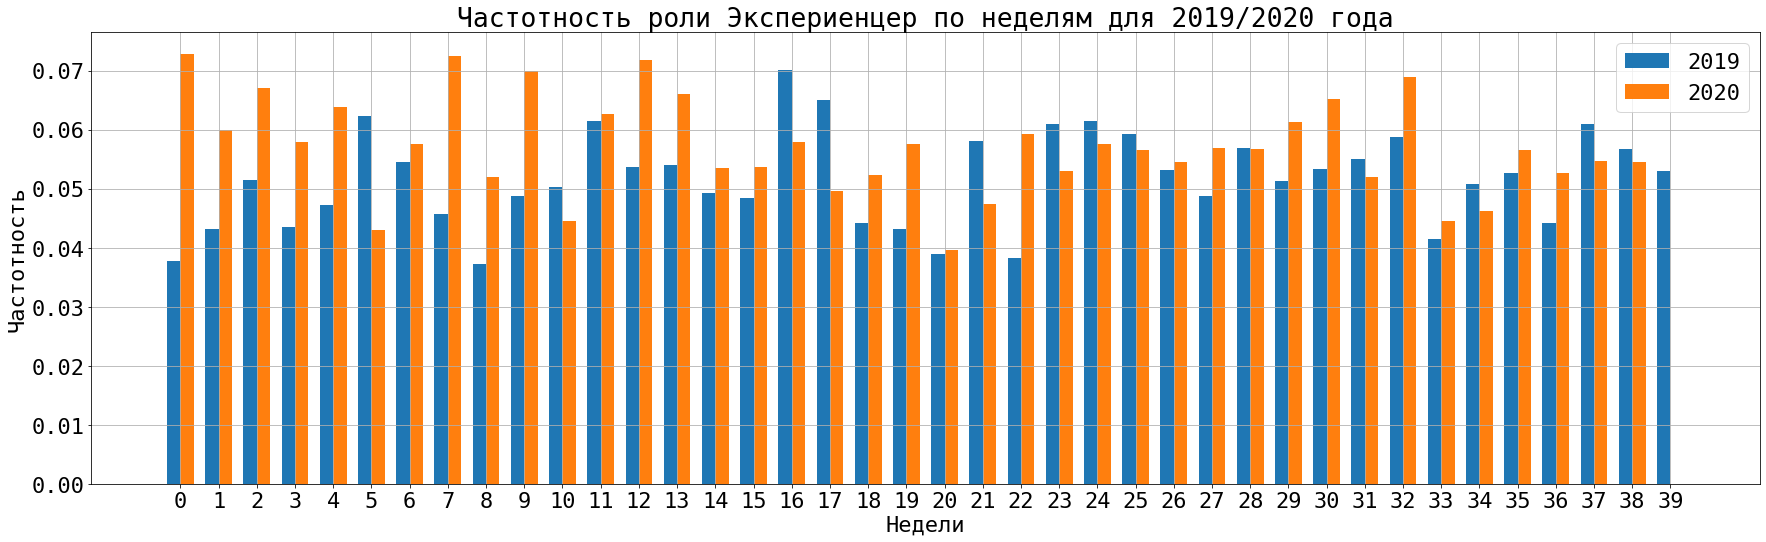

In [201]:
plot_data('экспериенцер', 'clauses', res2, 'роли Экспериенцер')

In [183]:
roleset

{'инструмент', 'каузатив', 'каузатор', 'объект', 'экспериенцер'}

In [ ]:
f

In [ ]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
def get_most_prob_tags(word, morph):
    variants = morph.parse(word)
    max_score = max(x.score for x in variants)
    variants = filter(
        lambda x: x.score == max_score,
        variants
    )
    variants = list(map(lambda x: x.tag, variants))
    return variants

def get_morph_string(parse):
    predicate = [x.text for x in razdel.tokenize(parse['predicate'])]
    arguments = parse['arguments']
    arguments = [[x.text for x in razdel.tokenize(arg)] for arg in arguments]
    predicate_tags = [get_most_prob_tags(x, morph) for x in predicate]
    arguments_tags = [[get_most_prob_tags(x, morph) for x in arg] for arg in arguments]
    
    arguments_str = ""
    for i in range(len(arguments)):
        words = arguments[i]
        for j in range(len(words)):
            word = words[j]
            tags = arguments_tags[i][j]
            tags = list(map(tag2str, tags))
            arg_str = f"{word}#[{'/'.join(tags)}]"
            arguments_str += arg_str + ";"
            
    predicate_str = ""
    for i in range(len(predicate)):
        word = predicate[i]
        tags = predicate_tags[i]
        tags = list(map(tag2str, tags))
        predicate_str += f"{word}#[{'/'.join(tags)}]"
        
    result_str = f"Предикат={predicate_str}||Аргументы={arguments_str}"
        
    return result_str

In [ ]:
get_morph_string(parse_res[0])

In [ ]:
for obj in tqdm(parse_res):
    if obj['predicate'] != 'NOT FOUND':
        obj['morph'] = get_morph_string(obj)
        obj['arguments'] = ";".join(obj['arguments'])

In [ ]:
parse_res[0]

In [ ]:
parse = pd.DataFrame(parse_res)

In [ ]:
parse['arguments'] = parse['arguments'].str.lower()

In [ ]:
words_exp = []
words_caus = []
for i in parse.itertuples():
    if i.role == 'экспериенцер':
        words_exp.append(i.arguments)
    elif i.role == 'каузатор':
        words_caus.append(i.arguments)

In [ ]:
words_exp = Counter(words_exp)
words_caus = Counter(words_caus)

In [ ]:
words_caus.most_common()

In [ ]:
parse['_pr'] = parse['predicate'] + "+" + parse['role']

In [ ]:
parse.to_csv("parsed_roles-100.csv", index=False, encoding='utf-8')

In [ ]:
pairs = parse['_pr'].value_counts().to_dict().keys()

In [ ]:
parse = parse.sample(frac=1.0).reset_index(drop=True)

In [ ]:
refined = []
for pair in tqdm(pairs):
    refined += parse[parse['_pr'] == pair].head(10).to_dict(orient='records')

In [ ]:
new_parse = pd.DataFrame(parse)

In [ ]:
new_parse = new_parse.loc[:, ['role', 'orig_clause_text', 'predicate','arguments','formatted_clause_text', 'morph']]

In [ ]:
new_parse.to_csv("./parsed_roles-100.csv")

In [ ]:
with_parse = new_parse[new_parse['role'] != 'NOT FOUND']

In [ ]:
without_parse = new_parse[new_parse['morph'] == 'NOT FOUND']

In [ ]:
result = pd.concat([
    with_parse.drop_duplicates(subset='formatted_clause_text'),
    without_parse.drop_duplicates(subset='orig_clause_text')
])

In [ ]:
result = result.sample(n=300).reset_index(drop=True)

In [ ]:
result.to_csv("./parsed_roles-300.csv", index=False, encoding='utf-8')